### Import Packages and CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import re
import statsmodels.api as sm

In [2]:
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.calibration import calibration_curve

In [3]:
# Load cleaned data

cleaned_data = pd.read_csv('../predict_re/survey_responses.csv')
cleaned_data.columns = cleaned_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace("'",'')

### Tidy Data

In [4]:
data = cleaned_data.copy()

data['year'] = data['year'].map({'First-year': 1,
                                 'Second-year': 2,
                                 'Third-year': 3,
                                 'Fourth-year': 4})
data['gender'] = data['gender'].map({'Female': 'F', 'Male': 'M', 'Non-binary': 'NB', 'Prefer not to specify': 'unspecified'})
data['relationship_status'] = (data['relationship_status'] == 'In a relationship').astype(int)
data['is_long_distance'] = data.apply(lambda row: row['is_long_distance'] if row['relationship_status'] == 1 else np.nan, axis=1)
data['sexuality'] = data['sexuality'].str.lower().map({'heterosexual/straight': 'heterosexual', 'homosexual/gay': 'homosexual', 'prefer not to specify': 'unspecified'})
data['commute'] = (data['residence_type'] == 'Commute').astype(int)
data['job_status'] = (data['job_status'].isin(['Part-Time', 'Employed'])).astype(int)
data['minor'] = data['minor'].apply(lambda x: 0 if pd.isna(x) or x.strip().lower() == 'none' else 1)
data.drop(columns=['residence_type'], inplace=True)
data.drop(columns=['is_transfer'], inplace=True)
data.rename(columns={'is_transfer.1': 'is_transfer'}, inplace=True)

In [5]:
# Function to map majors to departments

def get_dept(major):
    major = major.strip().lower().split('&')
    dept = []
    for m in major:
        m = m.strip()
        if pd.isna(m):
            dept.append('Undeclared')
        elif re.search(r'bio', m, re.IGNORECASE):
            dept.append('NaturalSci')
        elif re.search(r'engineering', m, re.IGNORECASE):
            dept.append('Engineering')
        elif re.search(r'psych|sociology|political science|anthropology|urban|ethnic|economics', m, re.IGNORECASE):
            dept.append('SocSci')
        elif re.search(r'computer|data', m, re.IGNORECASE):
            dept.append('CompSci')
        elif re.search(r'chem|environment|geo', m, re.IGNORECASE):
            dept.append('NaturalSci')
        elif re.search(r'cognitive', m, re.IGNORECASE):
            dept.append('CogSci')

        elif re.search(r'planning|interaction|neural|molecular|evolution', m, re.IGNORECASE):
            continue
        else:
            dept.append('ArtsHum')
    return list(set(dept))

In [6]:
# Add new columns for department -- second department if double major

data['dept'] = data['major'].apply(get_dept)
data['double_major'] = data['dept'].apply(lambda x: 1 if len(x) > 1 else 0)
data['dept1'] = data['dept'].apply(lambda x: x[0] if len(x) >= 1 else np.nan)
data['dept2'] = data['dept'].apply(lambda x: x[1] if len(x) >= 2 else np.nan)

In [7]:
# Reorder columns for easier viewing

data = data[['gender', 'race', 'is_hispaniclatino', 'sexuality', 'year', 'is_transfer', 'commute', 
             'college', 'major', 'minor', 'dept1', 'dept2', 'double_major', 'is_stem', 'gpa',
             'club_general', 'club_professional', 'club_recreational', 'club_athletic', 
             'club_cultural', 'club_skilldev', 'club_other', 'is_greek', 'job_status', 'outings_per_week',
             'relationship_status', 'longest_relationship_months', 'num_romantic_involvements',
             'met_partner_ucsd', 'is_long_distance']]

In [8]:
data.head()

,gender,race,is_hispaniclatino,sexuality,year,is_transfer,commute,college,major,minor,...,club_skilldev,club_other,is_greek,job_status,outings_per_week,relationship_status,longest_relationship_months,num_romantic_involvements,met_partner_ucsd,is_long_distance
0,F,White/Caucasian,0,heterosexual,3,0,0,Eighth,General Biology,0,...,0,0,0,1,2.0,0,0.0,0,0,NaN
1,F,Asian,0,heterosexual,3,0,0,Muir,Data Science,1,...,1,0,0,0,1.0,0,24.0,2,0,NaN
2,F,Multiracial,0,NaN,2,0,0,Seventh,Mathematics–Economics,1,...,0,0,0,1,4.0,0,10.0,2,0,NaN
3,M,White/Caucasian,0,heterosexual,1,0,0,Marshall,Mathematics–Economics,0,...,0,0,0,0,2.0,0,4.0,1,0,NaN
4,F,Asian,0,heterosexual,1,0,0,Revelle,Cognitive Science,0,...,0,0,1,0,2.0,0,8.0,2,0,NaN


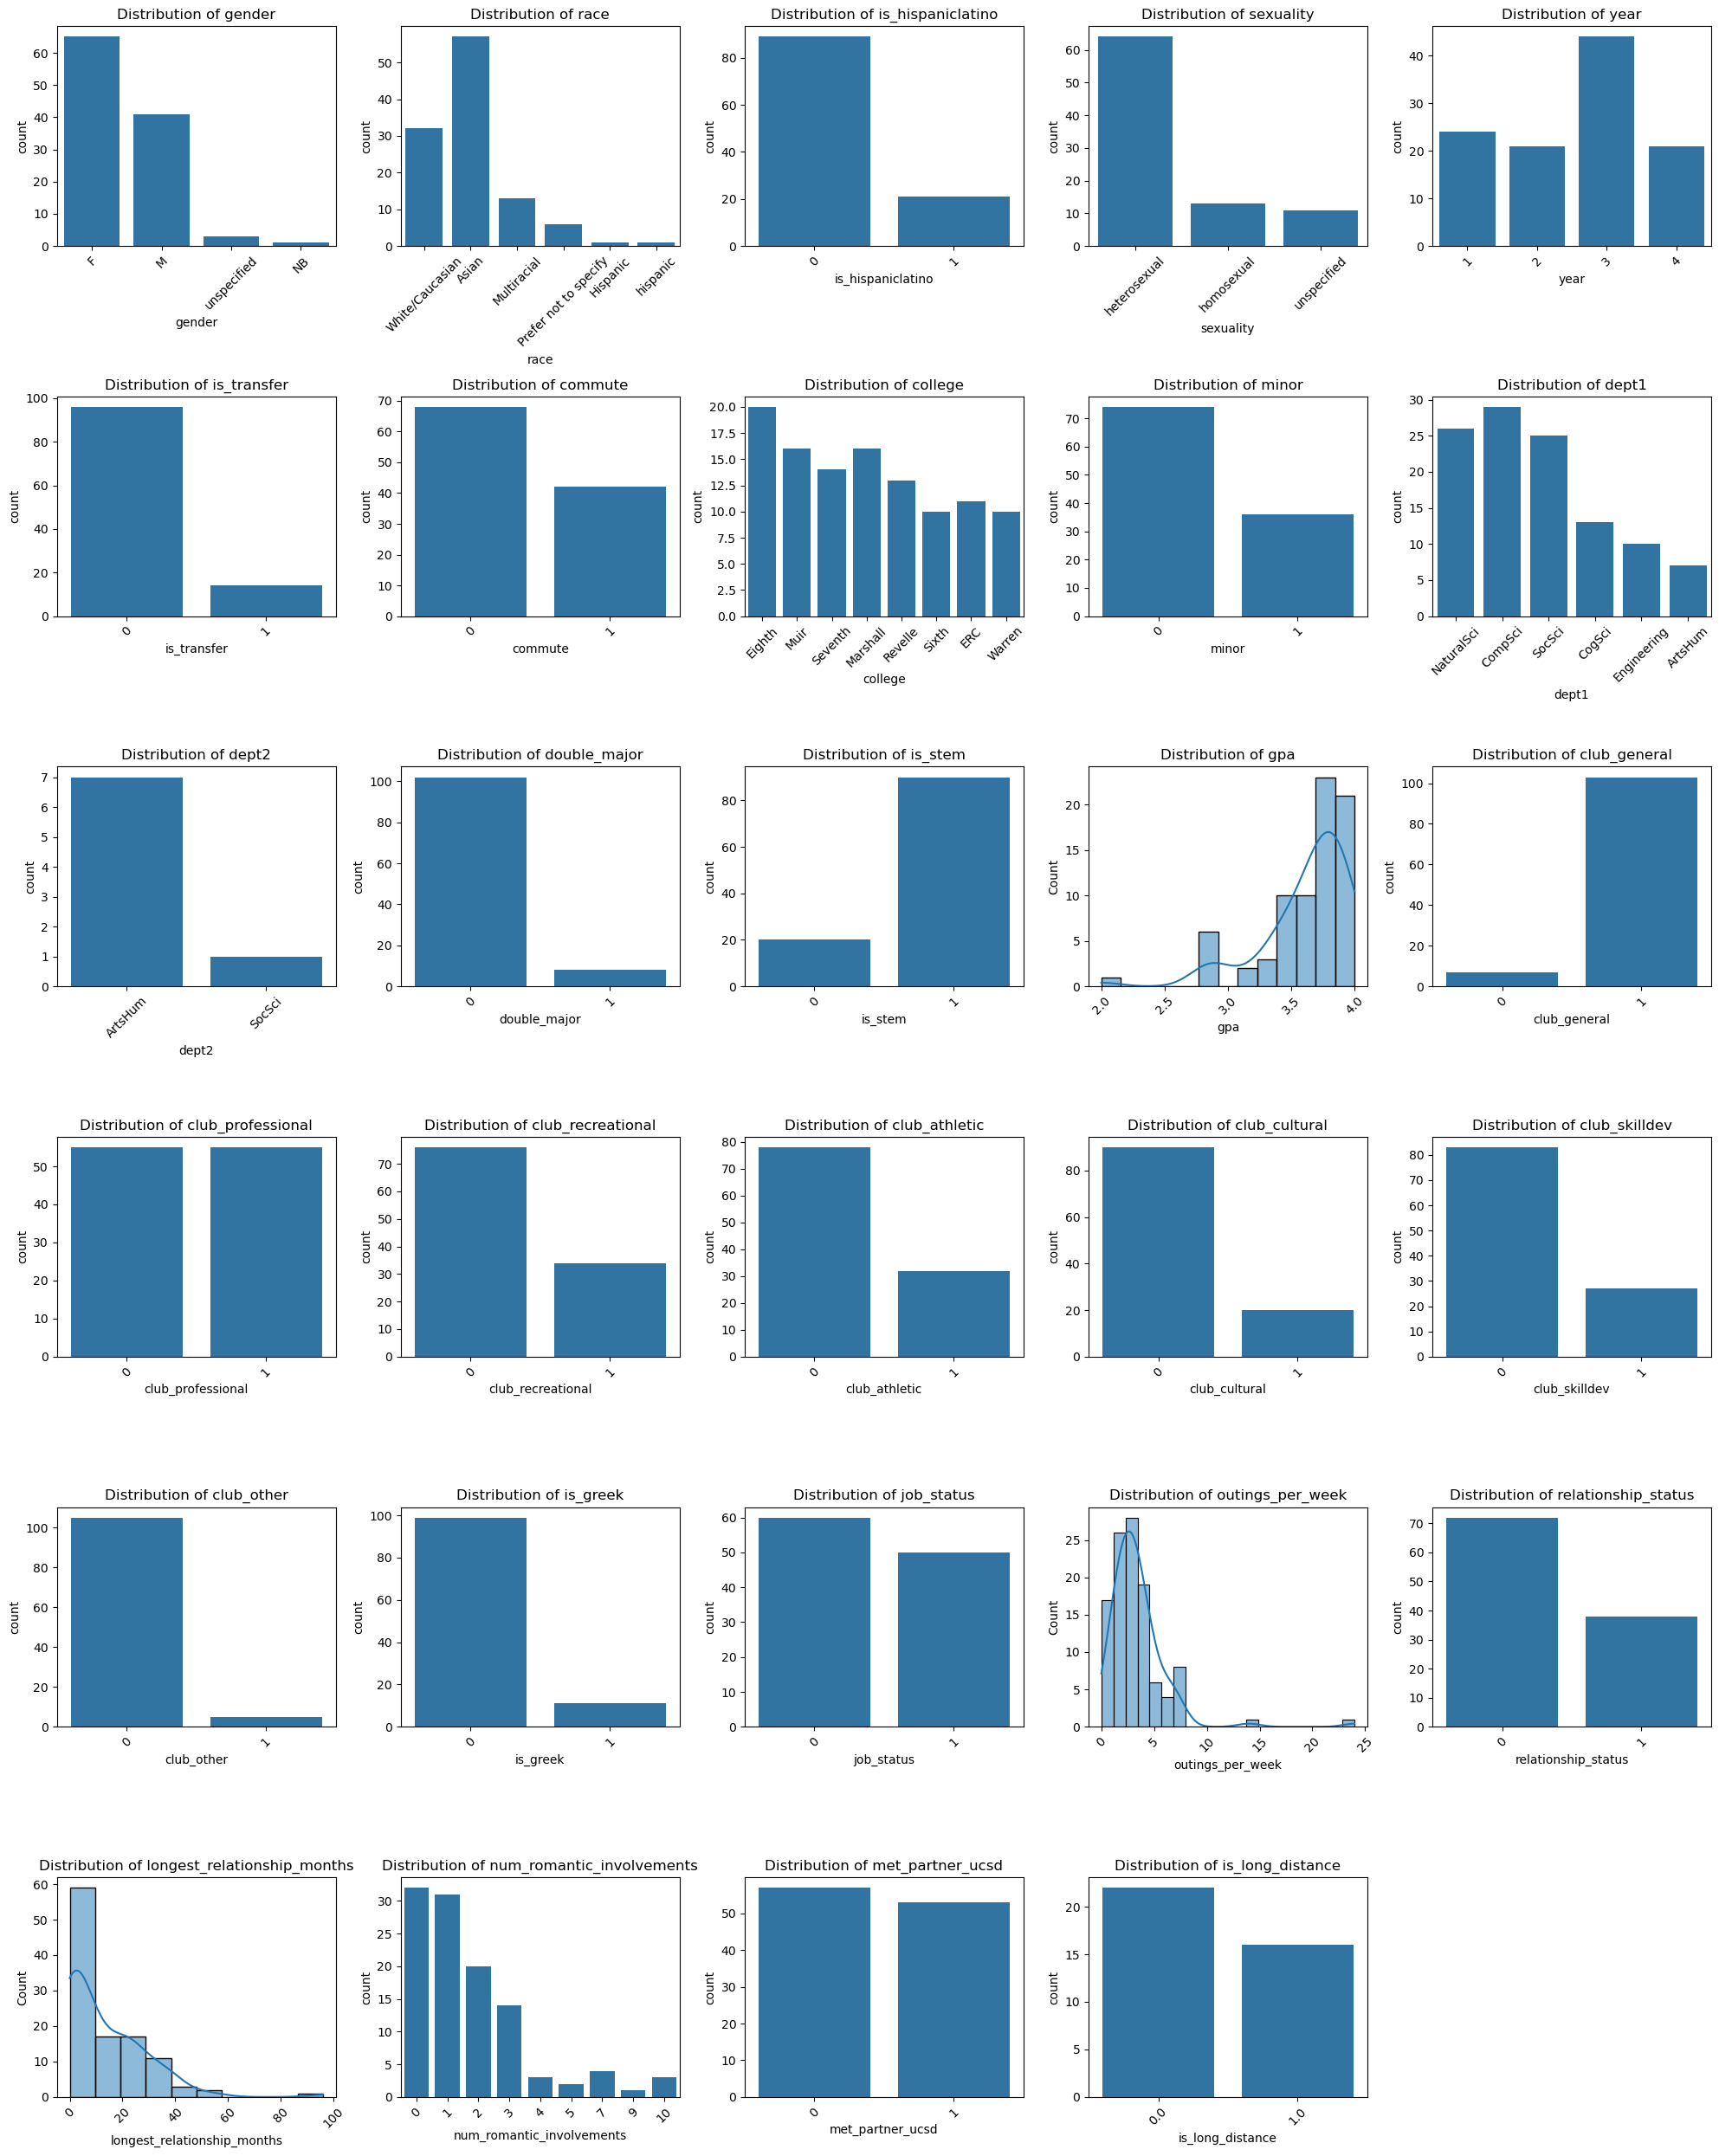

In [9]:
# Plot distributions of all variables
fig, axes = plt.subplots(6, 5, figsize=(20,25))
axes = axes.flatten()
cols_plotted = data.columns[data.columns != 'major']
for i, col in enumerate(cols_plotted):
    if col in ['major']:
        continue
    if data[col].dtype == 'object' or data[col].nunique() <= 10:
        sns.countplot(data=data, x=col, ax=axes[i])
    else:
        sns.histplot(data=data, x=col, kde=True, ax=axes[i])

    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Zero-mass of num_romantic_involvements: 0.2909090909090909
Mean of num_romantic_involvements: 1.8363636363636364
The variance of num_romantic_involvements: 4.963803169307757


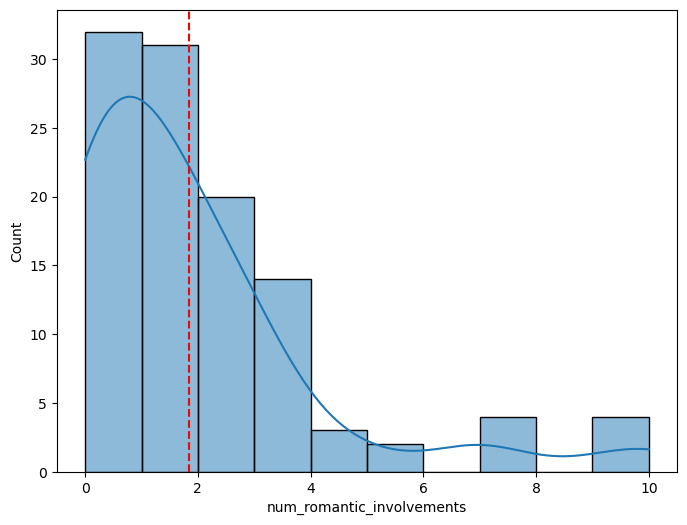

In [10]:
# Plot distribution of num_romantic_involvements for diagnostics
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='num_romantic_involvements', kde=True, bins=10)
plt.axvline(data['num_romantic_involvements'].mean(), color='red', linestyle='--', label='Mean') # Add mean line

print("Zero-mass of num_romantic_involvements:", (data['num_romantic_involvements'] == 0).mean())
print("Mean of num_romantic_involvements:", data['num_romantic_involvements'].mean())
print("The variance of num_romantic_involvements:", data['num_romantic_involvements'].var())

Characteristics of this distribution:

    - Heavy right skew
    - Large zero-mass
    - Count-like
    - Overdispersed


Based on the distribution of num_romantic_involvements OLS is not a reasonable method for modeling this data.

### Diagnostics for binary variables

In [11]:
# Balance diagnosis for binary columns -- flag columns with high imbalance (>90/10)
binary_cols = ['is_hispaniclatino', 'commute', 'is_stem', 'is_greek', 'job_status', 'relationship_status', 'is_long_distance',
               'club_general', 'club_professional', 'club_recreational', 'club_athletic', 
               'club_cultural', 'club_skilldev', 'club_other', 'double_major']

for col in binary_cols:
    counts = data[col].value_counts(normalize=True)
    if counts.max() > 0.9:
        print(f"High imbalance detected in column '{col}': {counts.to_dict()}")

High imbalance detected in column 'club_general': {1: 0.9363636363636364, 0: 0.06363636363636363}
High imbalance detected in column 'club_other': {0: 0.9545454545454546, 1: 0.045454545454545456}
High imbalance detected in column 'double_major': {0: 0.9272727272727272, 1: 0.07272727272727272}


### Create one-hot encoded dataframe

In [12]:
# One-hot encode categorical variables
onehot_cols = ['year', 'dept1', 'dept2'] # columns to one-hot encode (subject to change, but keep dept1 and dept2)

data_onehot = pd.get_dummies(data, columns=onehot_cols, dtype=int)

# Combine one-hot encoded department columns into single department columns
suffixes = set(data_onehot.columns[data_onehot.columns.str.contains('dept')].map(lambda x: x.split("_")[-1]))
for suffix in suffixes:
    cols_to_sum = [col for col in data_onehot.columns if col.endswith(f'{suffix}')]
    data_onehot[f'dept_{suffix}'] = data_onehot[cols_to_sum].sum(axis=1)
    data_onehot.drop(columns=cols_to_sum, inplace=True)

In [13]:
# Drop identify characteristics columns (not used in prediction)
data_onehot_x = data_onehot.drop(columns=['gender', 'race', 'is_hispaniclatino', 'sexuality', 'major', 'is_long_distance', 'college',
                                          'is_transfer'], inplace=False)

# Remove multicollinear columns (based on columns created during one-hot encoding) -- dept1 and dept2 always retained
data_onehot_x.drop(columns= ['double_major'], inplace=True) 

In [14]:
data_onehot_x.head()

,commute,minor,is_stem,gpa,club_general,club_professional,club_recreational,club_athletic,club_cultural,club_skilldev,...,year_1,year_2,year_3,year_4,dept_CogSci,dept_Engineering,dept_CompSci,dept_NaturalSci,dept_ArtsHum,dept_SocSci
0,0,0,1,3.69,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,1,1,3.72,1,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,0,1,1,3.70,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,1,4.00,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,1,NaN,1,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


### Look at distribution of num_romantic_involvements between each class of each binary variable


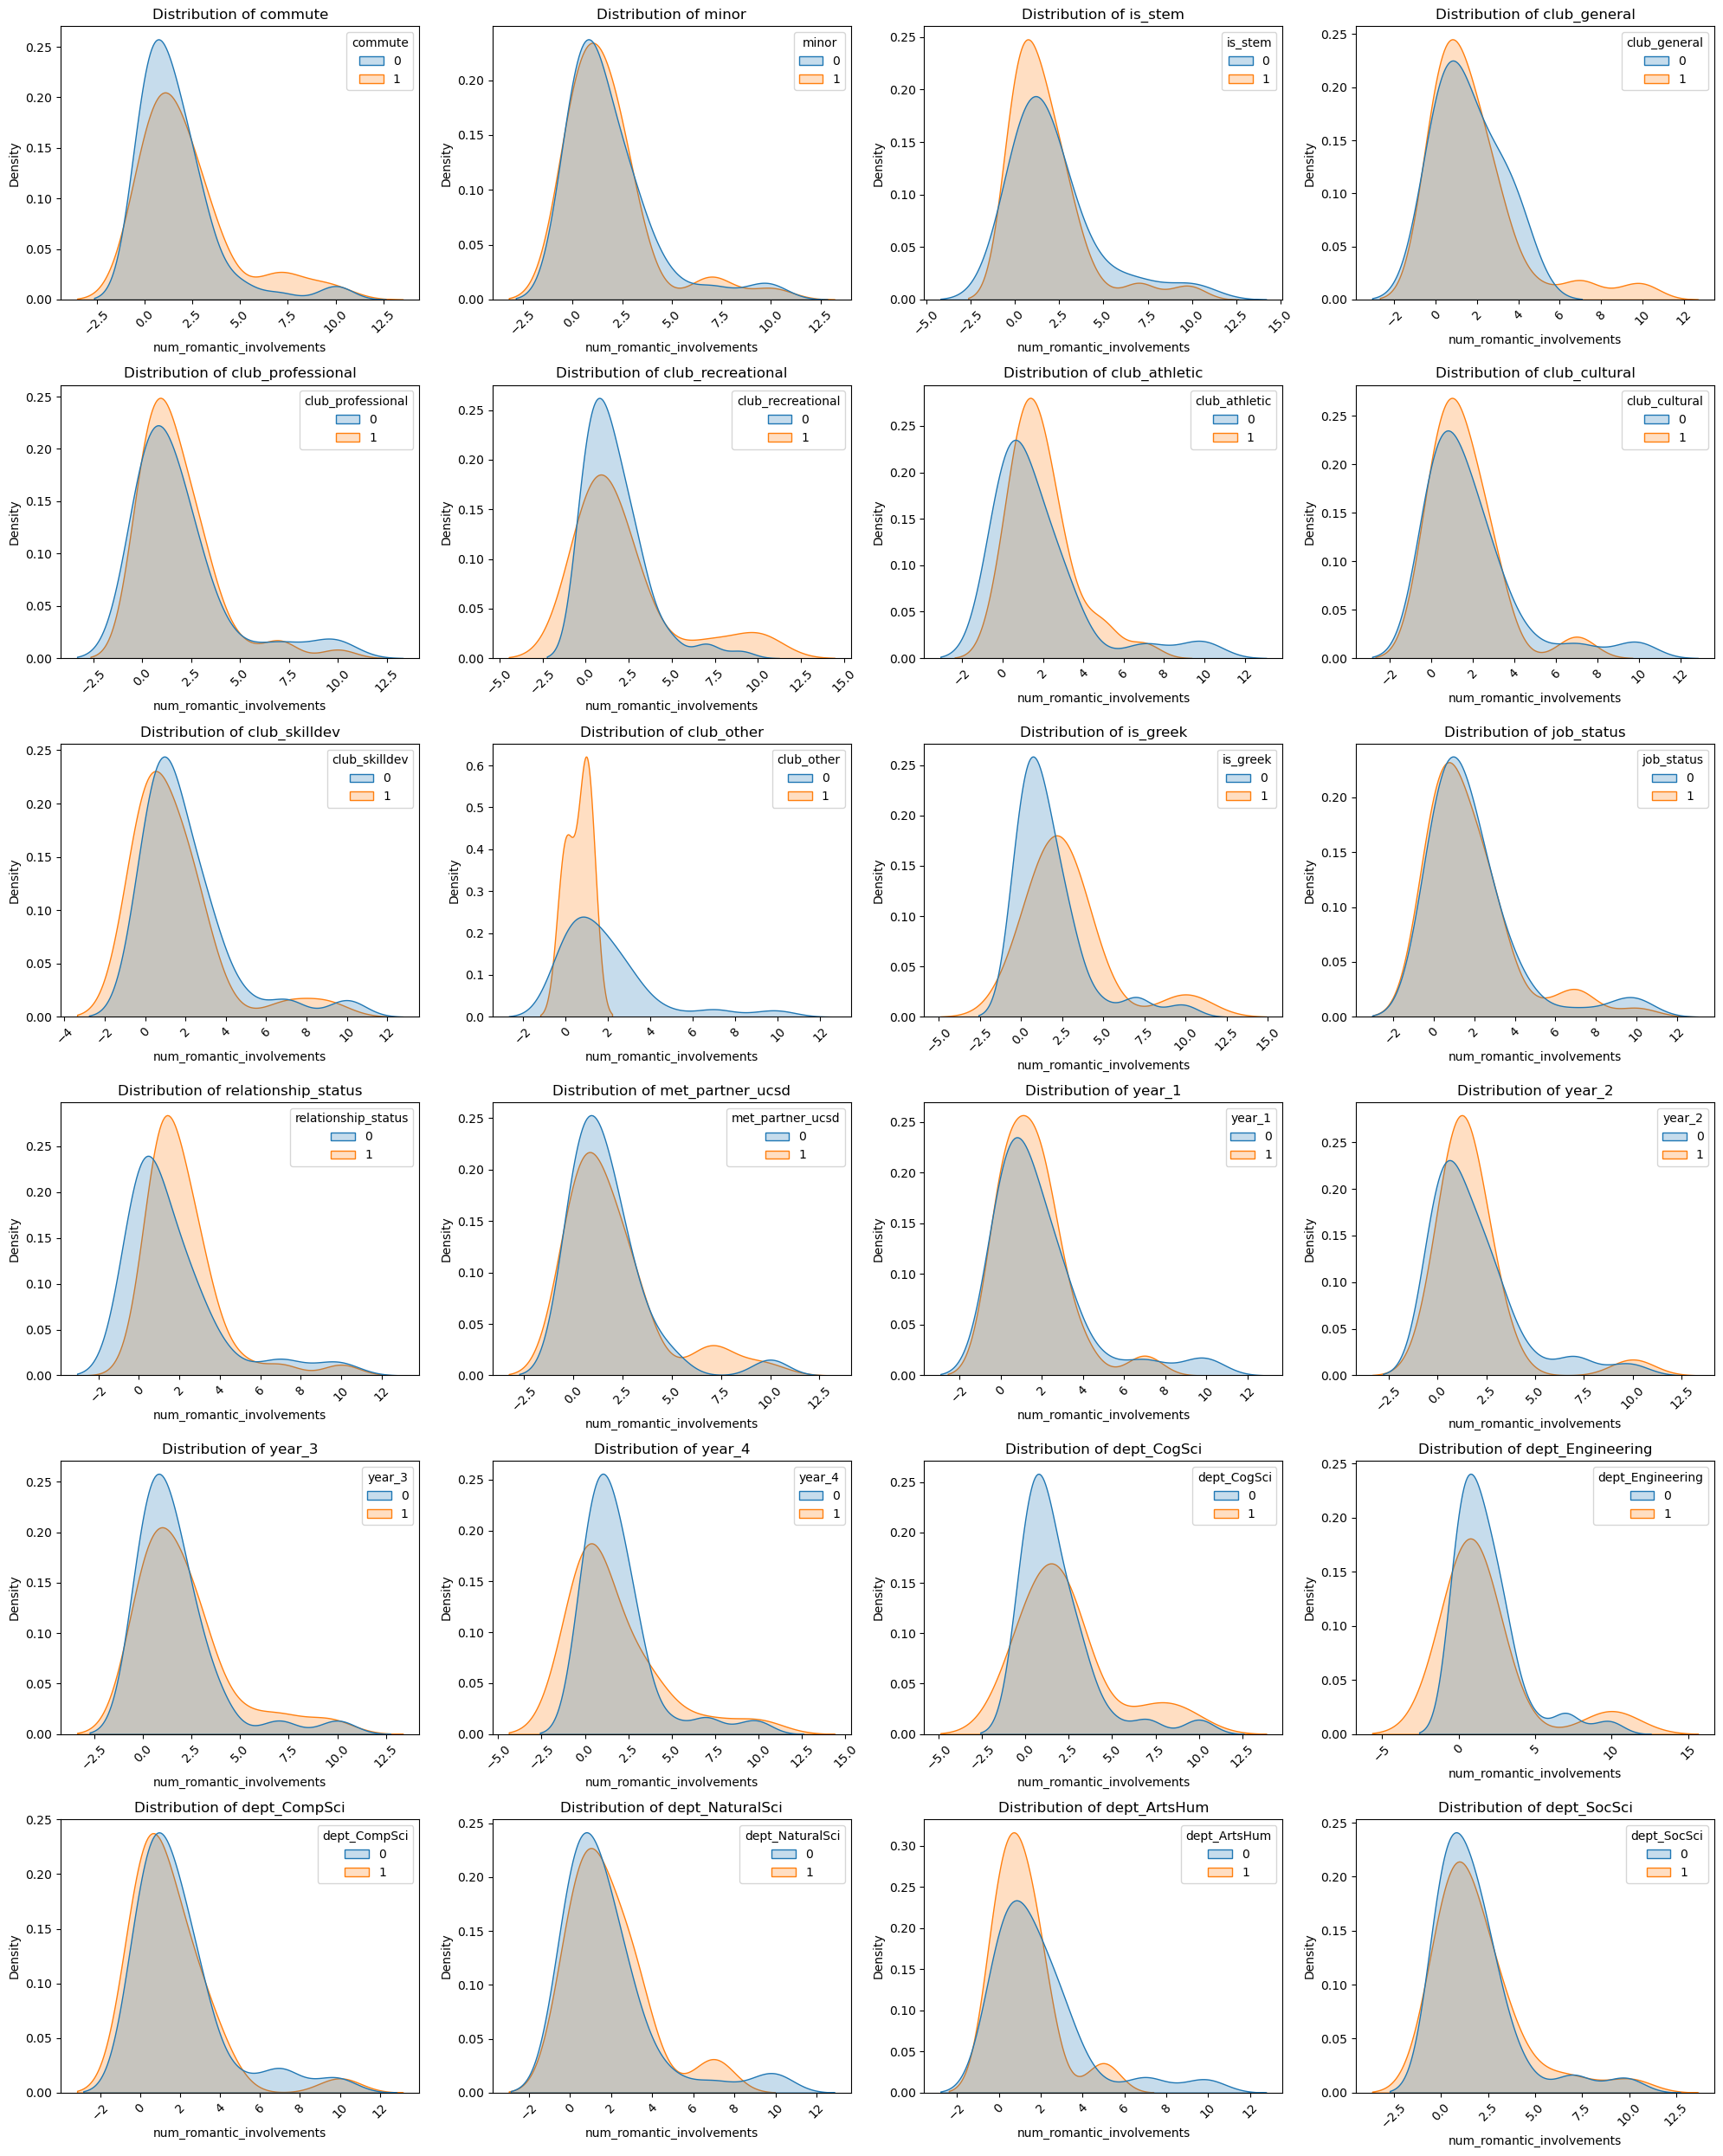

In [15]:
binary_cols_onehot = [col for col in data_onehot_x.columns if data_onehot_x[col].nunique() == 2]

fig, axes = plt.subplots(6, 4, figsize=(20,25))
axes = axes.flatten()
cols_plotted = data_onehot_x.columns[data_onehot_x.columns != 'major']

for i, col in enumerate(binary_cols_onehot):
    sns.kdeplot(data=data_onehot_x, x='num_romantic_involvements', hue=col, ax=axes[i], fill=True, common_norm=False,)

    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
# More Diagnostics for each binary variable
summaries = []

for col in binary_cols_onehot:
    tmp = (
        data_onehot_x
        .groupby(col)['num_romantic_involvements']
        .agg(['mean', 'median', 'std', 'count'])
    )
    
    # Add column name as first index level
    tmp['variable'] = col
    
    # Move variable into index to make it a MultiIndex later
    tmp = tmp.set_index('variable', append=True)
    
    # Swap index order so: (variable, 0/1)
    tmp = tmp.swaplevel(0, 1)
    
    summaries.append(tmp)

# Combine into a single dataframe
diagnostics_df = pd.concat(summaries).sort_index()

diagnostics_df

mean  median       std  count
variable                                                
club_athletic       0  1.794872     1.0  2.451392     78
                    1  1.937500     2.0  1.584960     32
club_cultural       0  1.900000     1.0  2.341852     90
                    1  1.550000     1.0  1.637553     20
club_general        0  1.571429     1.0  1.511858      7
                    1  1.854369     1.0  2.272632    103
club_other          0  1.895238     1.0  2.261398    105
                    1  0.600000     1.0  0.547723      5
club_professional   0  1.890909     1.0  2.477101     55
                    1  1.781818     1.0  1.969122     55
club_recreational   0  1.671053     1.0  1.776800     76
                    1  2.205882     1.0  3.002821     34
club_skilldev       0  1.963855     1.0  2.243939     83
                    1  1.444444     1.0  2.172084     27
commute             0  1.617647     1.0  2.044501     68
                    1  2.190476     1.0  2.481523     42
dept_ArtsHum        0  1.937500     1.0  2.316133     96
                    1  1.142857     1.0  1.350621     14
dept_CogSci         0  1.762887     1.0  2.159153     97
                    1  2.384615     2.0  2.724532     13
dept_CompSci        0  1.950617     1.0  2.285286     81
                    1  1.517241     1.0  2.063643     29
dept_Engineering    0  1.850000     1.0  2.157323    100
                    1  1.700000     1.0  2.983287     10
dept_NaturalSci     0  1.821429     1.0  2.329283     84
                    1  1.884615     1.0  1.904246     26
dept_SocSci         0  1.797619     1.0  2.205031     84
                    1  1.961538     1.0  2.340611     26
is_greek            0  1.727273     1.0  2.165679     99
                    1  2.818182     2.0  2.638870     11
is_stem             0  2.200000     1.0  2.546411     20
                    1  1.755556     1.0  2.158397     90
job_status          0  1.883333     1.0  2.292890     60
                    1  1.780000     1.0  2.169266     50
met_partner_ucsd    0  1.701754     1.0  2.052567     57
                    1  1.981132     1.0  2.413827     53
minor               0  1.878378     1.0  2.257121     74
                    1  1.750000     1.0  2.195775     36
relationship_status 0  1.666667     1.0  2.391299     72
                    1  2.157895     2.0  1.867594     38
year_1              0  1.918605     1.0  2.372465     86
                    1  1.541667     1.0  1.614585     24
year_2              0  1.853933     1.0  2.279107     89
                    1  1.761905     1.0  2.047065     21
year_3              0  1.666667     1.0  2.107374     66
                    1  2.090909     1.0  2.399789     44
year_4              0  1.865169     1.0  2.122343     89
                    1  1.714286     0.0  2.685942     21

In [17]:
# Create screening table for binary variables

mean_wide = diagnostics_df['mean'].unstack(level=1)
mean_wide['mean_diff'] = mean_wide[1] - mean_wide[0]
mean_wide['mean_ratio'] = mean_wide[1] / mean_wide[0].replace(0, np.nan)
counts = diagnostics_df['count'].unstack(level=1)
counts['min_group_n'] = counts.min(axis=1)
if 'zero_pct' in diagnostics_df.columns:
    zero_wide = diagnostics_df['zero_pct'].unstack(level=1)
    zero_wide['zero_diff'] = zero_wide[1] - zero_wide[0]
else:
    zero_wide = None
screen = mean_wide.join(counts['min_group_n'])

if zero_wide is not None:
    screen = screen.join(zero_wide['zero_diff'])

screen

,0,1,mean_diff,mean_ratio,min_group_n
variable,,,,,
club_athletic,1.794872,1.937500,0.142628,1.079464,32
club_cultural,1.900000,1.550000,-0.350000,0.815789,20
club_general,1.571429,1.854369,0.282940,1.180053,7
club_other,1.895238,0.600000,-1.295238,0.316583,5
club_professional,1.890909,1.781818,-0.109091,0.942308,55
club_recreational,1.671053,2.205882,0.534830,1.320056,34
club_skilldev,1.963855,1.444444,-0.519411,0.735515,27
commute,1.617647,2.190476,0.572829,1.354113,42
dept_ArtsHum,1.937500,1.142857,-0.794643,0.589862,14


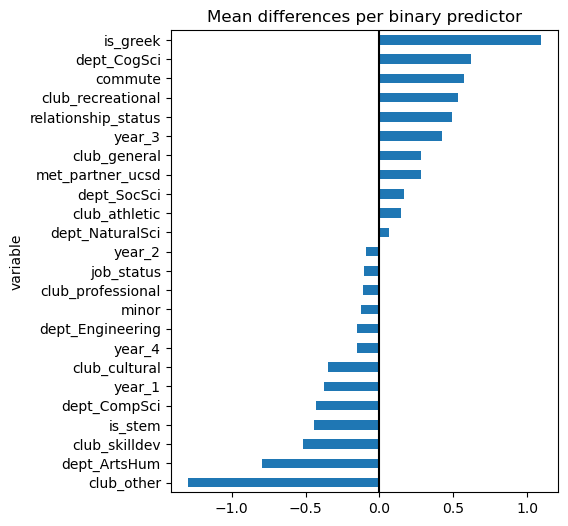

In [18]:
# Plot mean differences for each binary predictor
screen['mean_diff'].sort_values().plot(kind='barh', figsize=(5,6))
plt.axvline(0, color='black')
plt.title("Mean differences per binary predictor")
plt.show()

### Create Sparse Dataframe for Prediction

- Social Predictors: club involvement, outings per week, greek life involvement
- Academic Predictors: year, major department, minor (T/F), is stem

In [19]:
# Drop columns with high imbalance from predictors
unbalanced_cols = ['club_other', 'club_general']
data_onehot_sparse = data_onehot_x.drop(columns=unbalanced_cols)

# Drop columns with incomplete data, one-hot reference variables, and irrelevant variables
cols_to_drop = ['gpa', 'year_1', 'met_partner_ucsd', 'job_status', 'commute', 'relationship_status', 'longest_relationship_months']
data_onehot_sparse.drop(columns=cols_to_drop, inplace=True)

soc_predictors = ['club_professional', 'club_recreational',
       'club_athletic', 'club_cultural', 'club_skilldev', 'is_greek',
       'outings_per_week']
aca_predictors = ['minor', 'is_stem', 'year_2', 'year_3',
       'year_4', 'dept_SocSci', 'dept_CogSci', 'dept_Engineering',
       'dept_NaturalSci', 'dept_CompSci', 'dept_ArtsHum']


### Create Logistic Regression Model to Predict >0 Total Relationships

In [20]:
# Create binary outcome variable for whether student has had at least one romantic involvement

data_oneplus = data_onehot_sparse.copy()
data_oneplus['oneplus'] = (data_oneplus['num_romantic_involvements'] > 0).astype(int)
y_vec = data_oneplus['oneplus'].values
X_aca = data_oneplus[aca_predictors]
X_soc = data_oneplus[soc_predictors]


--- Academic Predictors ---
CV AUCs: [0.56666667 0.47142857 0.53125    0.30729167 0.671875  ]
Mean CV AUC: 0.5097023809523809
Accuracy: 0.5454545454545454
Confusion matrix (default 0.5):
 [[ 1  9]
 [ 6 17]]
RMSE: 0.521405827119193
Brier score: 0.2718640365538498
Intercept: 0.27679247385520733
Coefficients:
  minor: -0.3528
  is_stem: 0.0896
  year_2: 0.5251
  year_3: 0.0818
  year_4: -0.7759
  dept_SocSci: -0.3614
  dept_CogSci: -0.1366
  dept_Engineering: 0.0855
  dept_NaturalSci: -0.3758
  dept_CompSci: -0.5899
  dept_ArtsHum: -0.5516


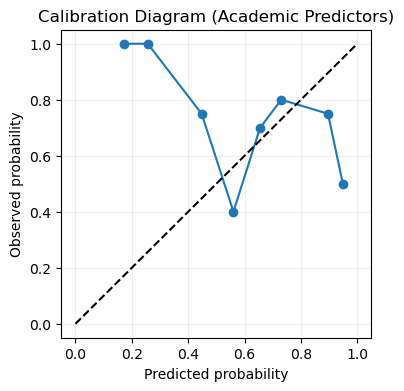


--- Social Predictors ---
CV AUCs: [0.8952381  0.52380952 0.58854167 0.71875    0.41666667]
Mean CV AUC: 0.6286011904761905
Accuracy: 0.6060606060606061
Confusion matrix (default 0.5):
 [[ 6  4]
 [ 9 14]]
RMSE: 0.4820251814457627
Brier score: 0.23234827554782042
Intercept: 0.1767142233446006
Coefficients:
  club_professional: 0.2316
  club_recreational: 0.0595
  club_athletic: 0.5031
  club_cultural: -0.1728
  club_skilldev: -0.4303
  is_greek: 0.4080
  outings_per_week: -0.1084


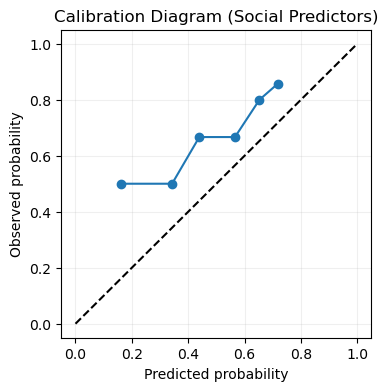

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, brier_score_loss, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve

for X, predictors, name in [(X_aca, aca_predictors, 'Academic Predictors'), (X_soc, soc_predictors, 'Social Predictors')]:
    print(f"\n--- {name} ---")
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver='saga', class_weight='balanced'))
    
    # Cross-validated AUC
    auc = cross_val_score(pipe, X, y_vec, cv=skf, scoring='roc_auc', n_jobs=-1)
    print("CV AUCs:", auc)
    print("Mean CV AUC:", auc.mean())

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_vec, stratify=y_vec, test_size=0.3, random_state=0)
    pipe.fit(X_train, y_train)

    # Predictions
    probs_test = pipe.predict_proba(X_test)[:,1]
    preds_test = pipe.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, preds_test)
    print("Accuracy:", acc)

    # Confusion matrix
    cm = confusion_matrix(y_test, preds_test)
    print("Confusion matrix (default 0.5):\n", cm)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, probs_test))
    print("RMSE:", rmse)

    # Brier score
    print("Brier score:", brier_score_loss(y_test, probs_test))

    # Model summary: coefficients and intercept
    coefs = pipe.named_steps['logisticregression'].coef_.flatten()
    intercept = pipe.named_steps['logisticregression'].intercept_[0]
    print("Intercept:", intercept)
    print("Coefficients:")
    for p, c in zip(predictors, coefs):
        print(f"  {p}: {c:.4f}")

    # Calibration plot
    prob_true, prob_pred = calibration_curve(y_test, probs_test, n_bins=10)
    plt.figure(figsize=(4,4))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed probability")
    plt.title(f"Calibration Diagram ({name})")
    plt.grid(alpha=0.2)
    plt.show()


--- Academic Predictors ---
CV AUCs: [0.56666667 0.47142857 0.53125    0.30729167 0.671875  ]
Mean CV AUC: 0.5097023809523809
Test Accuracy: 0.5454545454545454
Test RMSE: 0.5214065954149241
Brier score: 0.2718648377421823
Confusion matrix (default 0.5):
 [[ 1  9]
 [ 6 17]]

Statsmodels Logistic Regression Summary:
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   77
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                           11
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.2083
Time:                        03:27:58   Log-Likelihood:                -36.473
converged:                       True   LL-Null:                       -46.067
Covariance Type:            nonrobust   LLR p-value:                   0.05780
                       coef    std err          z  

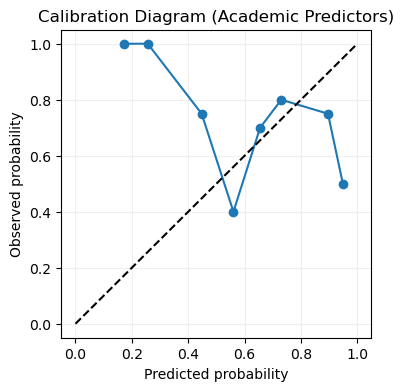


--- Social Predictors ---
CV AUCs: [0.8952381  0.52380952 0.58854167 0.71875    0.41666667]
Mean CV AUC: 0.6286011904761905
Test Accuracy: 0.6060606060606061
Test RMSE: 0.4820319571833662
Brier score: 0.23235480774602663
Confusion matrix (default 0.5):
 [[ 6  4]
 [ 9 14]]

Statsmodels Logistic Regression Summary:
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   77
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                            7
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.1185
Time:                        03:27:58   Log-Likelihood:                -40.606
converged:                       True   LL-Null:                       -46.067
Covariance Type:            nonrobust   LLR p-value:                    0.1421
                        coef    std err          z  

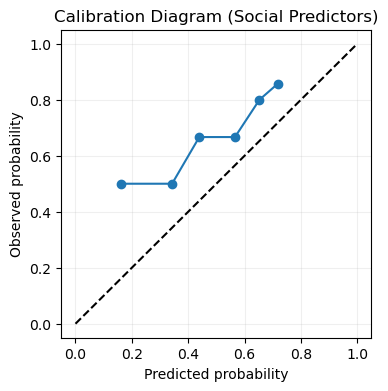

In [22]:
# Print detailed model statistics and calibration plots for each predictor set

for X, predictors, name in [(X_aca, aca_predictors, 'Academic Predictors'), (X_soc, soc_predictors, 'Social Predictors')]:
    print(f"\n--- {name} ---")
    
    # ---------------------------
    # Cross-validated AUC
    # ---------------------------
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver='saga', class_weight='balanced'))
    auc = cross_val_score(pipe, X, y_vec, cv=skf, scoring='roc_auc', n_jobs=-1)
    print("CV AUCs:", auc)
    print("Mean CV AUC:", auc.mean())
    
    # ---------------------------
    # Train/test split
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y_vec, stratify=y_vec, test_size=0.3, random_state=0)
    pipe.fit(X_train, y_train)

    # Predictions (scikit-learn)
    probs_test = pipe.predict_proba(X_test)[:,1]
    preds_test = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds_test)
    rmse = np.sqrt(mean_squared_error(y_test, probs_test))
    brier = brier_score_loss(y_test, probs_test)
    cm = confusion_matrix(y_test, preds_test)

    print("Test Accuracy:", acc)
    print("Test RMSE:", rmse)
    print("Brier score:", brier)
    print("Confusion matrix (default 0.5):\n", cm)
    
    # ---------------------------
    # Statsmodels logistic regression for coefficient stats
    # ---------------------------
    X_train_sm = sm.add_constant(X_train)  # add intercept
    logit_model = sm.Logit(y_train, X_train_sm)
    result = logit_model.fit(disp=False)

    print("\nStatsmodels Logistic Regression Summary:")
    print(result.summary())

    # Optional: make predictions using statsmodels
    X_test_sm = sm.add_constant(X_test)
    preds_test_sm = result.predict(X_test_sm)
    preds_class = (preds_test_sm >= 0.5).astype(int)

    # ---------------------------
    # Calibration plot
    # ---------------------------
    prob_true, prob_pred = calibration_curve(y_test, probs_test, n_bins=10)
    plt.figure(figsize=(4,4))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed probability")
    plt.title(f"Calibration Diagram ({name})")
    plt.grid(alpha=0.2)
    plt.show()

# NOTE: Confusion Matrix format
# [[TN, FP],
#  [FN, TP]]


### Negative Binomial Regression Models for Academic and Social Predictors

Only using the cases in which a participant has had at least one romantic relationship (removes influence of high zero-weight)

In [23]:
# Only analyze non-zero romantic involvement cases
data_onehot_sparse = data_onehot_sparse[data_onehot_sparse['num_romantic_involvements'] != 0]

In [24]:
# Set up outcome variable
target = 'num_romantic_involvements'
y = data_onehot_sparse[target]

In [25]:
# Negative Binomial Regression Model for Academic Predictors
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import NegativeBinomial

# outcome and predictors
X = sm.add_constant(data_onehot_sparse[aca_predictors])

# fit true Negative Binomial model (estimates dispersion)
aca_nbr = NegativeBinomial(y, X).fit()

print(aca_nbr.summary())

         Current function value: 1.883280
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
                         NegativeBinomial Regression Results                         
Dep. Variable:     num_romantic_involvements   No. Observations:                   78
Model:                      NegativeBinomial   Df Residuals:                       66
Method:                                  MLE   Df Model:                           11
Date:                       Thu, 04 Dec 2025   Pseudo R-squ.:                 0.04104
Time:                               03:27:59   Log-Likelihood:                -146.90
converged:                             False   LL-Null:                       -153.18
Covariance Type:                   nonrobust   LLR p-value:                    0.3221
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const   

/Users/sophieneale/miniforge3/envs/dsc190/lib/python3.14/site-packages/scipy/optimize/_optimize.py:1330: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/sophieneale/miniforge3/envs/dsc190/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
# Negative Binomial Regression Model for Social Predictors

# outcome and predictors
X = sm.add_constant(data_onehot_sparse[soc_predictors])

# fit true Negative Binomial model (estimates dispersion)
soc_nbr = NegativeBinomial(y, X).fit()

print(soc_nbr.summary())

Optimization terminated successfully.
         Current function value: 1.918666
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 19
                         NegativeBinomial Regression Results                         
Dep. Variable:     num_romantic_involvements   No. Observations:                   78
Model:                      NegativeBinomial   Df Residuals:                       70
Method:                                  MLE   Df Model:                            7
Date:                       Thu, 04 Dec 2025   Pseudo R-squ.:                 0.02302
Time:                               03:27:59   Log-Likelihood:                -149.66
converged:                              True   LL-Null:                       -153.18
Covariance Type:                   nonrobust   LLR p-value:                    0.4233
                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

### Analyze residuals plot of the two different predictor groups

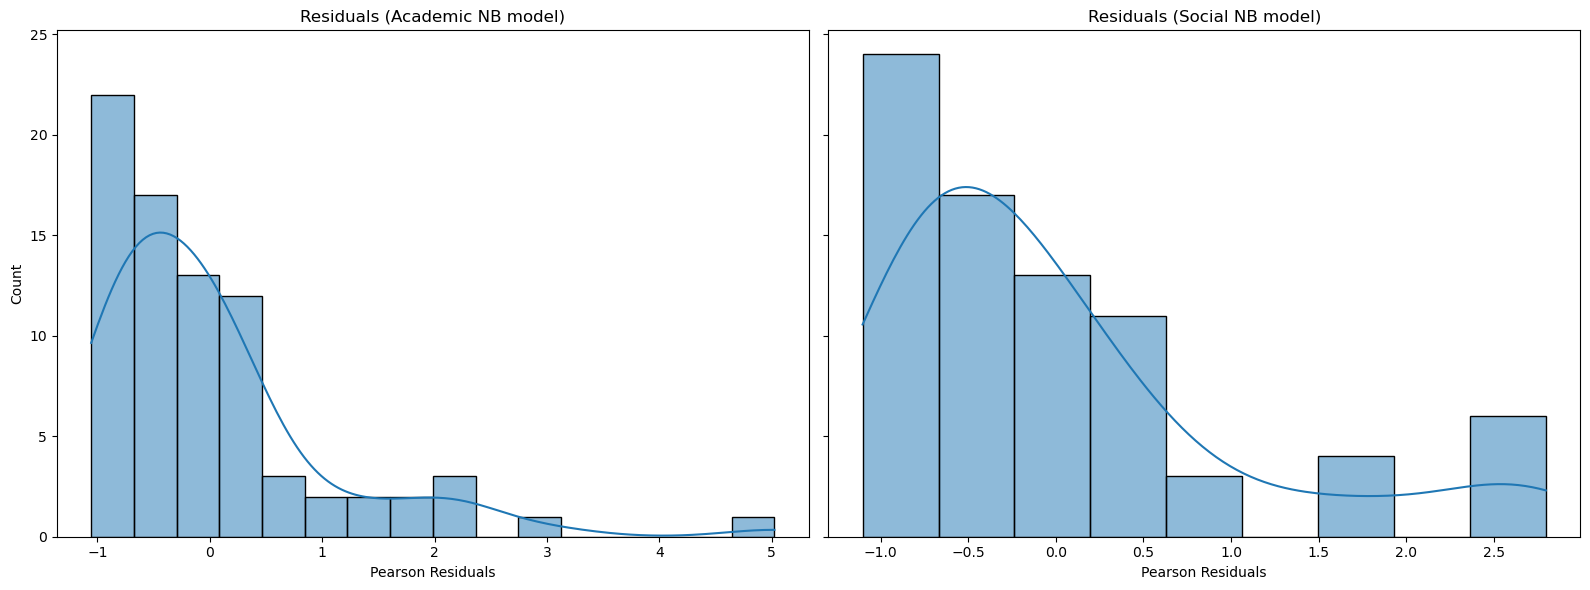

In [27]:
# Residuals histogram for both models

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for i, (model, name) in enumerate([(aca_nbr, 'Academic NB'), (soc_nbr, 'Social NB')]):
    resid = model.resid_pearson
    sns.histplot(resid, kde=True, ax=axes[i])
    axes[i].set_title(f"Residuals ({name} model)")
    axes[i].set_xlabel("Pearson Residuals")

plt.tight_layout()
plt.show()

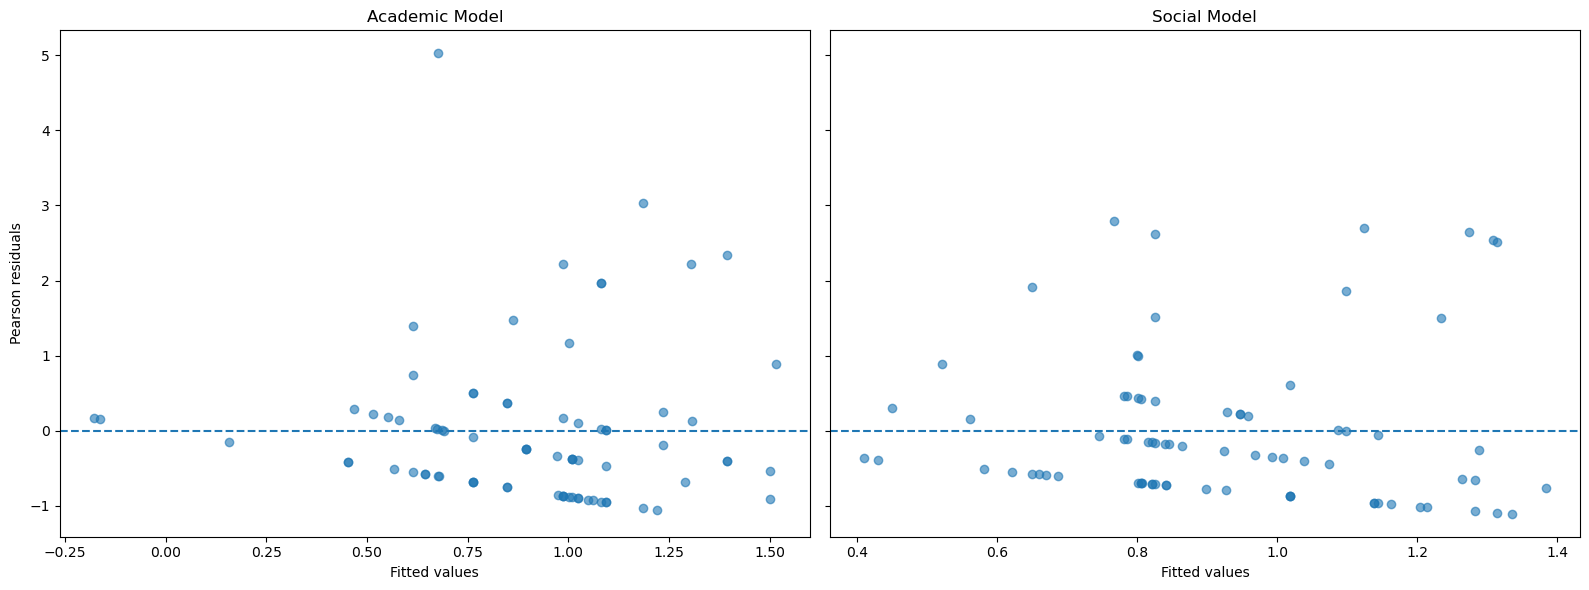

In [28]:
# Residuals vs Fitted for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Academic model
axes[0].scatter(aca_nbr.fittedvalues, aca_nbr.resid_pearson, alpha=0.6)
axes[0].axhline(0, linestyle='--')
axes[0].set_title("Academic Model")
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Pearson residuals")

# Social model
axes[1].scatter(soc_nbr.fittedvalues, soc_nbr.resid_pearson, alpha=0.6)
axes[1].axhline(0, linestyle='--')
axes[1].set_title("Social Model")
axes[1].set_xlabel("Fitted values")

# Improve spacing
plt.tight_layout()
plt.show()

No obvious funnel shape, model seems to be fit relatively well

### Analyze model performance

In [29]:
from sklearn.model_selection import KFold

for predictors, name in [(aca_predictors, 'Academic'), (soc_predictors, 'Social')]:
    print(f"\n{name} Model Cross-Validation:")

    X = data_onehot_sparse[predictors]
    X = sm.add_constant(X)

    y = data_onehot_sparse['num_romantic_involvements']

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae = []
    rmse = []

    for train_index, test_index in kf.split(X):

        # split data
        X_train = X.iloc[train_index]
        X_test  = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test  = y.iloc[test_index]

        # fit proper Negative Binomial model (dispersion estimated)
        model = NegativeBinomial(y_train, X_train)
        fit = model.fit(disp=False)

        # predict expected counts
        preds = fit.predict(X_test)

        # scoring
        mae.append(np.mean(np.abs(preds - y_test)))
        rmse.append(np.sqrt(np.mean((preds - y_test)**2)))

    print(f"Average MAE for {name} model: {np.mean(mae):.4f}")
    print(f"Average RMSE for {name} model: {np.mean(rmse):.4f}")


Academic Model Cross-Validation:
Average MAE for Academic model: 1.6289
Average RMSE for Academic model: 2.2985

Social Model Cross-Validation:
Average MAE for Social model: 1.9229
Average RMSE for Social model: 2.5850


/Users/sophieneale/miniforge3/envs/dsc190/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sophieneale/miniforge3/envs/dsc190/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sophieneale/miniforge3/envs/dsc190/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


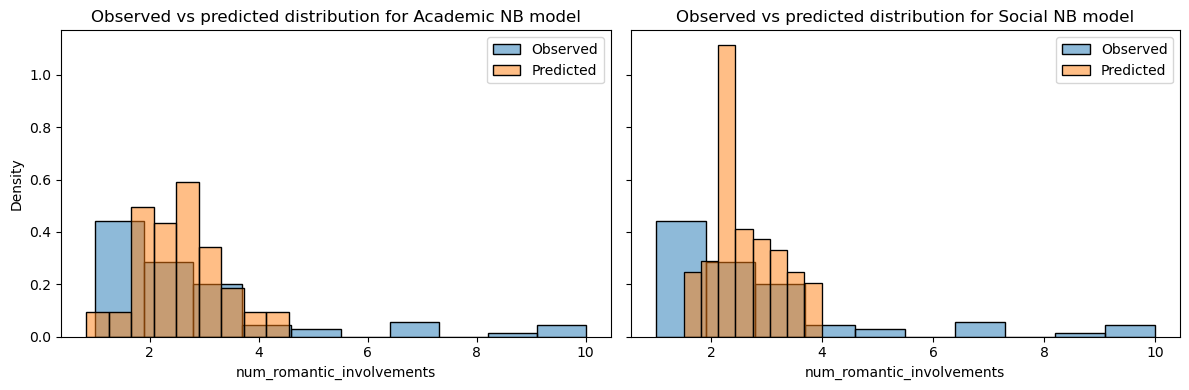

In [30]:
# Observed vs Predicted distributions for both models

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for i, (nb, name) in enumerate([(aca_nbr, 'Academic NB'), (soc_nbr, 'Social NB')]):
    sns.histplot(y, stat="density", label="Observed", alpha=0.5, ax=axes[i])
    sns.histplot(nb.predict(), stat="density", label="Predicted", alpha=0.5, ax=axes[i])
    axes[i].legend()
    axes[i].set_title("Observed vs predicted distribution for " + name + " model")

plt.tight_layout()
plt.show()

count    78.000000
mean      3.733036
std       1.894582
min       0.742525
25%       2.406361
50%       3.423571
75%       4.171495
max      10.491983
dtype: float64
count    78.000000
mean      2.588897
std       0.604657
min       1.506147
25%       2.229450
50%       2.350885
75%       2.999656
max       3.990282
dtype: float64


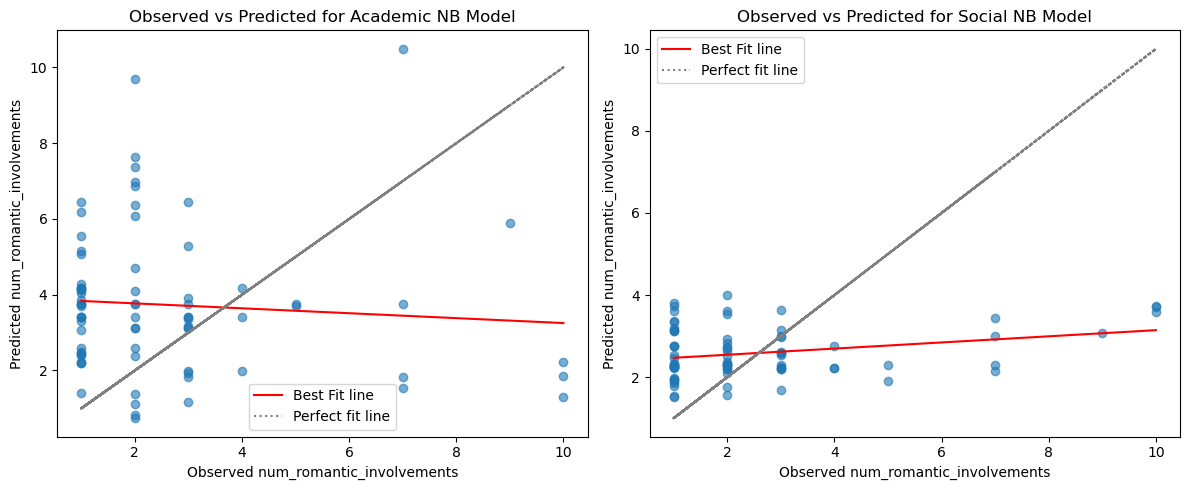

In [31]:
# Plot observed vs predicted for both models

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (nb, predictors, name) in enumerate([(aca_nbr, aca_predictors, 'Academic NB'), (soc_nbr, soc_predictors, 'Social NB')]):
    yhat = nb.predict(X)

    # Regression line between observed and predicted
    slope, intercept, r_value, p_value, std_err = stats.linregress(y, yhat)
    obs_line = np.linspace(y.min(), y.max(), 100)
    pred_line = intercept + slope * obs_line

    # plot
    axes[i].scatter(y, yhat, alpha=0.6)
    axes[i].plot(obs_line, pred_line, color='red', label='Best Fit line')
    axes[i].plot(y, y, linestyle=':', color='grey', label='Perfect fit line')

    axes[i].set_xlabel("Observed num_romantic_involvements")
    axes[i].set_ylabel("Predicted num_romantic_involvements")
    axes[i].set_title(f"Observed vs Predicted for {name} Model")
    axes[i].legend()

    print(yhat.describe())

plt.tight_layout()
plt.show()